# Standard Sparse AutoEncoder

In [1]:
from GatedSAE import (
    GatedTrainer,
    GatedAutoEncoder,
)

activation_dim, dict_size = 512, 512 * 64
device='cuda:0'
total_steps = 2000
trainer = GatedTrainer(
    activation_dim=512,
    dict_size=dict_size,
    lr=1e-3,
    warmup_steps=100, # lr warmup period at start of training and after each resample
    device=device,
    resample_steps=10, # how often to resample neurons
    steps=total_steps,
    initial_sparsity_penalty=5e-1
)

In [2]:
import os
import torch
from pathlib import Path

# resolve paths
output_dir = Path('outputs')
output_dir.mkdir(parents=True, exist_ok=True)
check_path = output_dir / 'params.pth'

# check save
ae = trainer.ae
torch.save(ae.state_dict(), check_path)

# check load
loaded_ae = GatedAutoEncoder.from_pretrained(check_path)
print(loaded_ae)
for p in loaded_ae.named_parameters():
    print(p[0], p[1].shape)


GatedAutoEncoder(
  (encoder): Linear(in_features=512, out_features=32768, bias=False)
  (decoder): Linear(in_features=32768, out_features=512, bias=False)
)
decoder_bias torch.Size([512])
r_mag torch.Size([32768])
gate_bias torch.Size([32768])
mag_bias torch.Size([32768])
encoder.weight torch.Size([32768, 512])
decoder.weight torch.Size([512, 32768])


In [3]:
# encode and decode
activations = torch.randn(4, activation_dim, device=device)
reconstructed_activations, features = ae(activations, output_features=True)
reconstructed_activations.shape, features.shape

(torch.Size([4, 512]), torch.Size([4, 32768]))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# setup
infos = {}
log_step = 5

# train
pbar = tqdm(total=total_steps)
for step in range(1, total_steps + 1):
    pbar.update(1)
    act = torch.randn(32, 512).to(device)
    trainer.update(step, act)
    if step % log_step == 0:
        with torch.no_grad():
            infos[step] = trainer.loss(act, step, logging=True)[3]

  0%|          | 0/2000 [00:00<?, ?it/s]

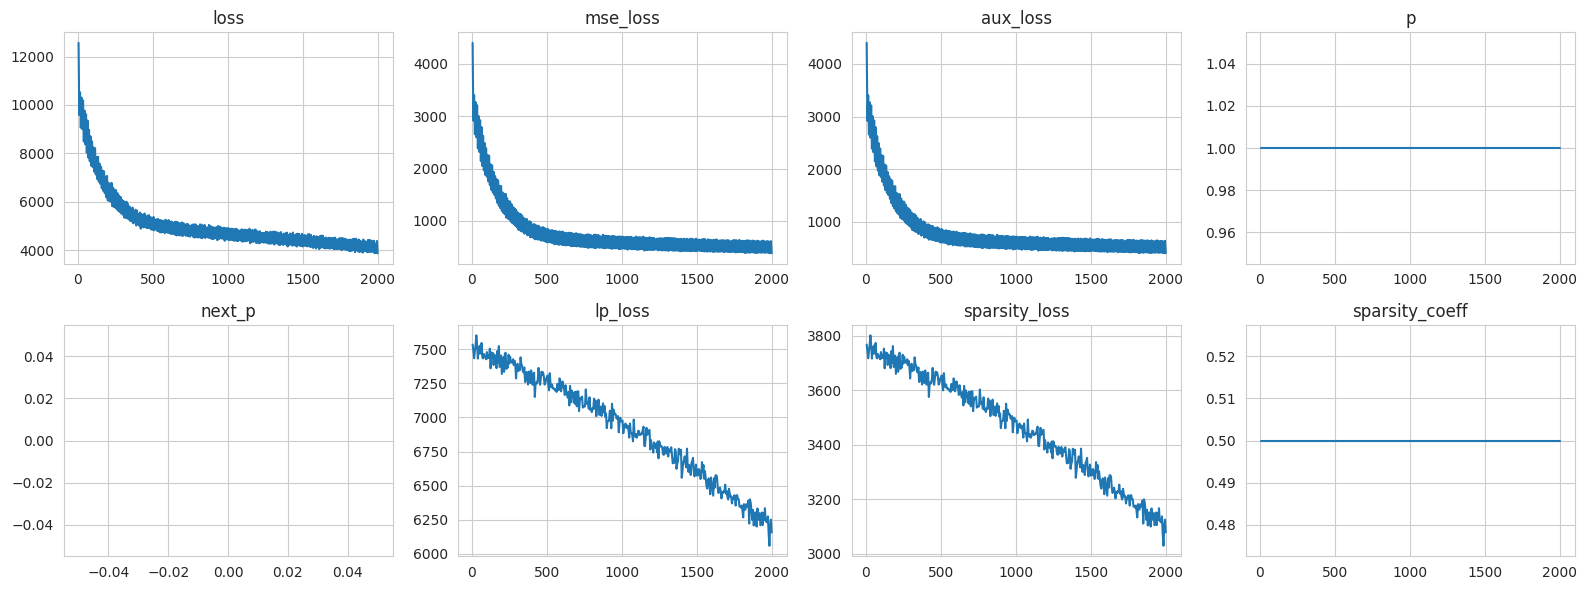

In [5]:
# show loss log
sns.set_style('whitegrid')
steps = sorted(list(infos.keys()))
names = list(infos[steps[0]].keys())
fig, axes = plt.subplots(2, len(names) // 2, figsize=(16, 6))
axes = axes.ravel()
for i in range(len(names)):
    name = names[i]
    sns.lineplot(x=steps, y=[infos[step][name] for step in steps], ax=axes[i])
    axes[i].set_title(name)
plt.tight_layout()
os.makedirs('assets', exist_ok=True)
plt.savefig('assets/loss.png')